# Face Value: Leveraging AI to Prevent Underage Alcohol Purchases in Supermarkets

**Project description**

The supermarket chain Good Seed would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage. You are asked to conduct that evaluation, so as you set to work, keep the following in mind:

The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol
Computer vision methods can be used to determine age of a person from a photo
The task then is to build and evaluate a model for verifying people's age
To start working on the task, you'll have a set of photographs of people with their ages indicated.

**Project Instructions**

- Perform exploratory data analysis to get an overall impression of the dataset.
- Train and evaluate the model (it needs to be done on the GPU platform).
- Combine your code, output and findings (from the previous points) in the final Jupyter notebook.
- Make conclusions of the model evaluation, add them to the notebook.

## Initialization

In [11]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import random

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

2025-06-18 17:09:48.568560: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
# Load to dataset
df_labels = pd.read_csv('/Users/sabrinamcfield/Data_Science_Projects-TripleTen-/project5_computer_vision/faces/labels.csv')

In [3]:
# Get a general overview of the data
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
# View a sample of the data
df_labels.sample(10)

,file_name,real_age
349,000349.jpg,55
3457,003457.jpg,30
6379,006383.jpg,96
3573,003573.jpg,13
7334,007356.jpg,6
4105,004105.jpg,34
3811,003811.jpg,21
2899,002899.jpg,14
722,000722.jpg,11
5022,005022.jpg,15


## EDA

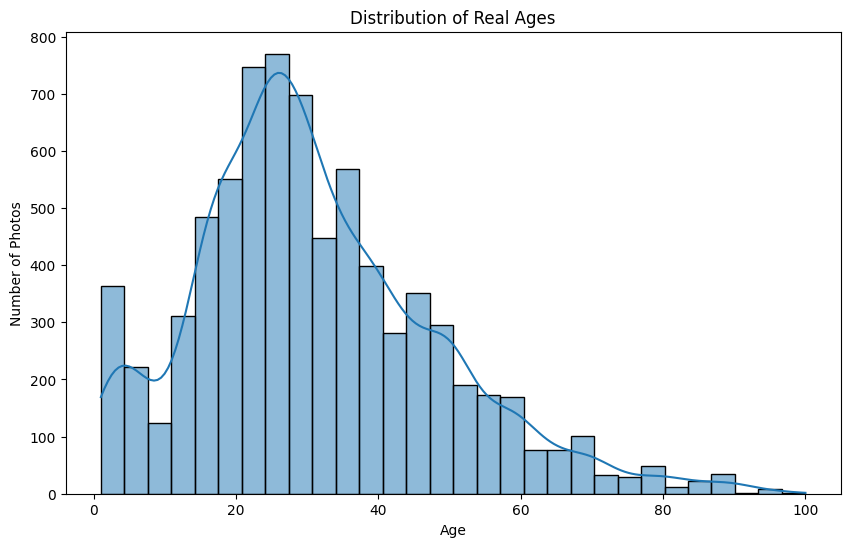

In [5]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_labels['real_age'], bins=30, kde=True)
plt.title('Distribution of Real Ages')
plt.xlabel('Age')
plt.ylabel('Number of Photos')

plt.savefig('images/age_distribution.png', dpi=300)
plt.show()

The age distribution in the dataset clearly leans toward younger individuals, with the majority of samples falling between 15 and 35 years old and peaking around age 25. As the ages increase beyond 35, the number of samples begins to taper off, and there are noticeably fewer images of individuals over 60. While there is some presence of children under 10, it's relatively limited compared to the concentration of young adults. Overall, the distribution forms a right-skewed curve, where most of the data is clustered at younger ages, and older age groups are sparsely represented.

In [6]:
# Load dataset
df_images = '/Users/sabrinamcfield/Data_Science_Projects-TripleTen-/project5_computer_vision/faces/final_files/'

In [7]:
# Get list of image file paths (filtering only image files)
image_files = [f for f in os.listdir(df_images) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

In [8]:
# Shuffle to ensure a mix
random.shuffle(image_files)

# Select 10–15 images
sample_images = image_files[:15]

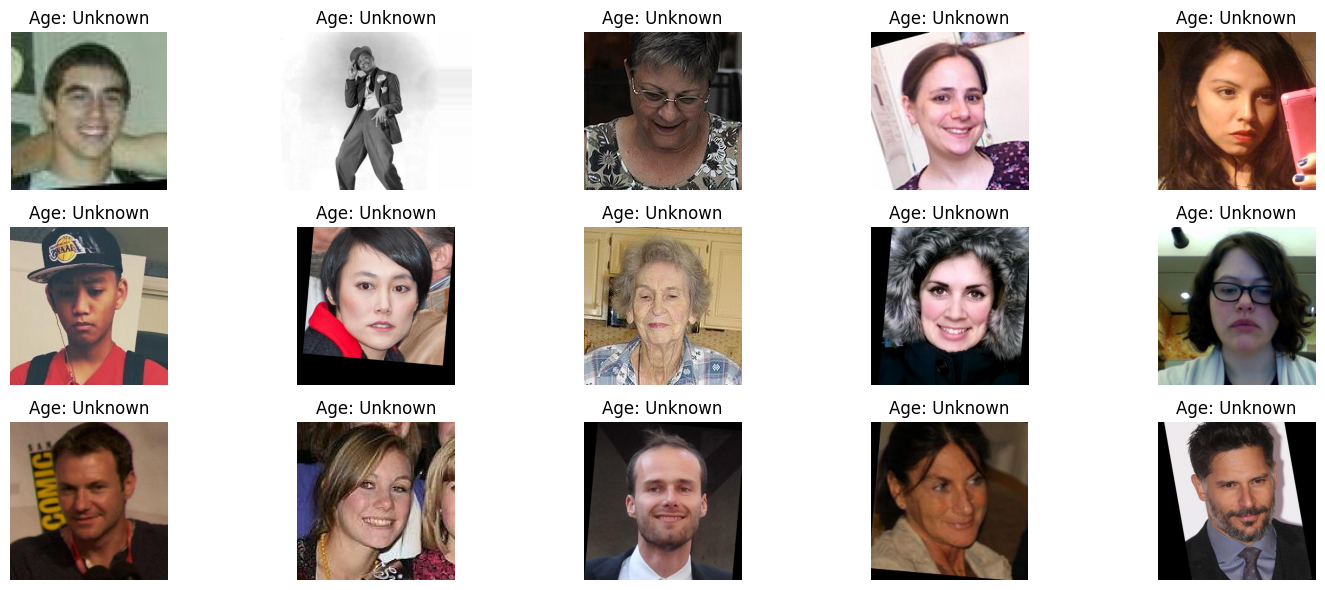

In [9]:
# Plot images
plt.figure(figsize=(15, 6))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(df_images, img_name)
    img = Image.open(img_path)
    
    # Attempt to extract age if in filename (e.g., "34_image123.jpg")
    age = img_name.split('_')[0] if '_' in img_name and img_name.split('_')[0].isdigit() else "Unknown"
    
    plt.subplot(3, 5, i+1)
    plt.imshow(img)
    plt.title(f"Age: {age}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Findings

Since the dataset contains far fewer examples of older individuals, the model will likely struggle to accurately predict older ages. There may be bias predictions toward younger ages when the model is uncertain. It may perform inconsistently across age groups, with better accuracy for common ranges such as age 20-35 years old.

## Modeling

Define the necessary functions to train the model on the GPU platform.

In [14]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    labels = pd.read_csv(f'/Users/sabrinamcfield/Data_Science_Projects-TripleTen-/project5_computer_vision/faces/labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
        directory=f'/Users/sabrinamcfield/Data_Science_Projects-TripleTen-/project5_computer_vision/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
    )

    return train_datagen_flow

In [15]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    labels = pd.read_csv(f'/Users/sabrinamcfield/Data_Science_Projects-TripleTen-/project5_computer_vision/faces/labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
        directory=f'/Users/sabrinamcfield/Data_Science_Projects-TripleTen-/project5_computer_vision/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',                                                 
        seed=12345
    )

    return test_datagen_flow

In [16]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    backbone = ResNet50(input_shape=input_shape,
                 include_top=False,
                 weights='imagenet')
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer= Adam(learning_rate=0.0005)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [17]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps= len(test_data)

    # Fit the model
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )

    return model

## Run on the GPU Platform

### Output

#### This is the code used to train model on GoogleCollab;

```python    
train_data = load_train('/content/drive/MyDrive/faces')  #uploaded files onto Google Drive
test_data = load_test('/content/drive/MyDrive/faces')  

model = create_model((224, 224, 3))

train_model(model, train_data, test_data)
```

#### Place the output from the GPU platform as an Markdown cell here.

```python 
Found 7591 validated image filenames.

Found 7591 validated image filenames.

Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
  
Epoch 1/20
238/238 - 255s - 1s/step - loss: 175.4186 - mae: 9.8783 - val_loss: 357.7365 - val_mae: 13.9960
Epoch 2/20
238/238 - 116s - 487ms/step - loss: 99.3167 - mae: 7.5855 - val_loss: 405.7027 - val_mae: 15.0375
Epoch 3/20
238/238 - 107s - 448ms/step - loss: 69.0847 - mae: 6.3482 - val_loss: 170.4594 - val_mae: 10.1169
Epoch 4/20
238/238 - 144s - 605ms/step - loss: 48.0268 - mae: 5.2732 - val_loss: 50.4217 - val_mae: 5.4109
Epoch 5/20
238/238 - 109s - 459ms/step - loss: 33.4638 - mae: 4.4442 - val_loss: 46.6232 - val_mae: 5.2403
Epoch 6/20
238/238 - 108s - 452ms/step - loss: 25.5029 - mae: 3.9067 - val_loss: 45.2958 - val_mae: 5.4714
Epoch 7/20
238/238 - 108s - 454ms/step - loss: 20.1224 - mae: 3.4338 - val_loss: 15.9466 - val_mae: 3.0531
Epoch 8/20
238/238 - 107s - 450ms/step - loss: 16.9804 - mae: 3.1541 - val_loss: 36.4787 - val_mae: 4.8037
Epoch 9/20
238/238 - 108s - 453ms/step - loss: 16.6888 - mae: 3.1390 - val_loss: 24.0210 - val_mae: 3.6792
Epoch 10/20
238/238 - 142s - 597ms/step - loss: 14.6222 - mae: 2.9299 - val_loss: 11.3991 - val_mae: 2.5399
Epoch 11/20
238/238 - 107s - 448ms/step - loss: 13.5621 - mae: 2.8277 - val_loss: 15.9646 - val_mae: 3.0932
Epoch 12/20
238/238 - 145s - 609ms/step - loss: 12.7348 - mae: 2.7172 - val_loss: 13.3240 - val_mae: 2.7471
Epoch 13/20
238/238 - 108s - 452ms/step - loss: 11.3393 - mae: 2.5681 - val_loss: 15.3092 - val_mae: 3.0204
Epoch 14/20
238/238 - 106s - 446ms/step - loss: 10.9211 - mae: 2.5226 - val_loss: 15.8127 - val_mae: 3.0569
Epoch 15/20
238/238 - 142s - 598ms/step - loss: 10.1991 - mae: 2.4463 - val_loss: 12.7843 - val_mae: 2.7898
Epoch 16/20
238/238 - 143s - 602ms/step - loss: 11.4534 - mae: 2.6072 - val_loss: 38.9391 - val_mae: 5.1580
Epoch 17/20
238/238 - 142s - 598ms/step - loss: 11.8259 - mae: 2.6230 - val_loss: 18.7896 - val_mae: 3.3314
Epoch 18/20
238/238 - 108s - 453ms/step - loss: 11.6619 - mae: 2.6032 - val_loss: 15.9663 - val_mae: 3.0810
Epoch 19/20
238/238 - 108s - 455ms/step - loss: 10.5708 - mae: 2.4792 - val_loss: 19.8666 - val_mae: 3.3623
Epoch 20/20
238/238 - 141s - 593ms/step - loss: 11.0091 - mae: 2.5104 - val_loss: 23.0129 - val_mae: 3.6655
<Sequential name=sequential, built=True>
```

In [18]:
# Reconstructed manually from markdown 
history_dict = {
    'loss': [
        175.42, 99.32, 69.08, 48.03, 33.46, 25.50, 20.12, 16.98, 16.69, 14.62,
        13.56, 12.73, 11.34, 10.92, 10.20, 11.45, 11.83, 11.66, 10.57, 11.01
    ],
    'val_loss': [
        357.74, 405.70, 170.46, 50.42, 46.62, 45.30, 15.95, 36.48, 24.02, 11.40,
        15.96, 13.32, 15.31, 15.81, 12.78, 38.94, 18.79, 15.97, 19.87, 23.01
    ],
    'mae': [
        9.88, 7.59, 6.35, 5.27, 4.44, 3.91, 3.43, 3.15, 3.14, 2.93,
        2.83, 2.72, 2.57, 2.52, 2.45, 2.61, 2.62, 2.60, 2.48, 2.51
    ],
    'val_mae': [
        14.00, 15.04, 10.12, 5.41, 5.24, 5.47, 3.05, 4.80, 3.68, 2.54,
        3.09, 2.75, 3.02, 3.06, 2.79, 5.16, 3.33, 3.08, 3.36, 3.67
    ]
}

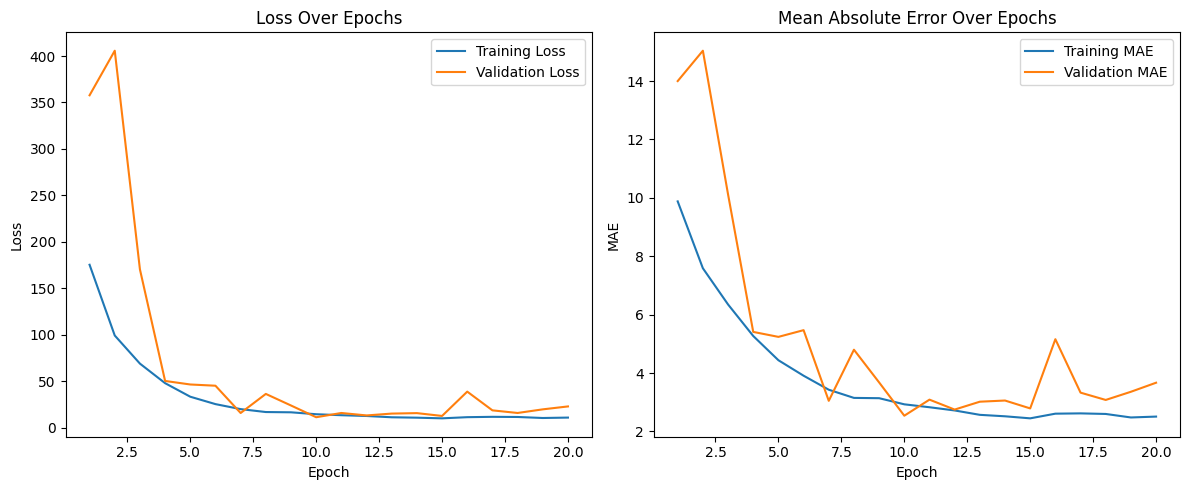

In [19]:
def plot_manual_history(history_dict, save_path=None):
    epochs = range(1, len(history_dict['loss']) + 1)
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_dict['loss'], label='Training Loss')
    plt.plot(epochs, history_dict['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # MAE Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_dict['mae'], label='Training MAE')
    plt.plot(epochs, history_dict['val_mae'], label='Validation MAE')
    plt.title('Mean Absolute Error Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

# Call the function
plot_manual_history(history_dict, save_path='images/model_training.png')

Training results revealed that the model began with high error rates—during the first epoch, the mean absolute error (MAE) on the training set was nearly 9.88 and even higher on the validation set at 13.99. However, by epoch 5, the model showed noticeable improvements, with validation MAE dropping to 5.24. The most accurate age predictions occurred between epochs 7 and 10, where validation MAE fell below 3.0 and reached a low of around 2.54 in epoch 10. This indicates that the model was able to learn strong age-related patterns and generalize them reasonably well to unseen data.

After this peak, however, the model’s validation performance started to fluctuate. While training MAE remained low—around 2.5—the validation MAE became less stable in later epochs, rising to over 5.0 at times and ending at 3.66 in epoch 20. This suggests that the model may have begun to overfit, particularly due to the skewed age distribution. Despite that, the final MAE values still reflect good predictive accuracy overall.

In conclusion, the model successfully learned to estimate age with a relatively low margin of error and shows strong promise for use in age verification at checkout. However, its consistency across underrepresented age groups—particularly older individuals—needs further investigation. Future iterations may benefit from rebalancing the training data or augmenting it with more diverse age samples to enhance generalization.

## Conclusion

This project set out to evaluate whether computer vision could help the supermarket chain, Good Seed, comply with alcohol sale laws by estimating a shopper’s age from facial images. Using a dataset of labeled photographs, a deep learning model was trained to make age predictions and assist in flagging underage customers at checkout.

Analysis of the dataset revealed a strong bias toward younger individuals, especially those aged 15 to 35, with far fewer examples of older adults. This imbalance created challenges for the model’s ability to generalize well across all age groups. During early training, the model’s predictions were quite inaccurate—mean absolute error (MAE) began near 9.9 for training and almost 14 for validation. However, performance steadily improved over time. By the 10th epoch, validation MAE dropped to around 2.5, reflecting the model’s improved understanding of age patterns in the data.

Toward the end of training, although the model continued to perform well on the training set, its accuracy on the validation set became inconsistent, suggesting some overfitting. The final validation MAE of 3.67 is still a solid result for age prediction, but it reflects a gap in generalization—likely tied to the lack of older individuals in the dataset.

To enhance performance further, collecting more data from underrepresented age groups would be beneficial. Incorporating advanced data augmentation techniques—such as those provided by the Albumentations library—could improve the model’s ability to recognize facial features under different conditions. Architectural enhancements like additional layers or normalization techniques, and testing optimizers like AdamW, may also help stabilize and improve performance.

As a tool for Good Seed, this system can provide an extra layer of age verification at checkout. While it shouldn’t replace human judgment or legal ID checks, it can act as a helpful prompt at self-checkout stations or during manual sales. I would argue that, it is much more reliable and easier to just compare the id or passport photo to the customer's face. In broader use, this technology could also support the sale of other age-restricted items such as tobacco or medications and even support age-based customer insights.

With appropriate consent, the model could power personalized marketing or help optimize store layout, inventory, and staffing by understanding the age trends of shoppers. Though not flawless, the model delivers practical value and shows promise as part of a smarter, more responsive retail environment.